About Dataset:


1.   URLs : link of each news article
2.   Headline : The main headline of news article
3.   Body : The whole body of news article
4.   Label : A label that marks weather news article is real or fake



0 : Real News

1 : Fake News

Importing the Dependencies

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import nltk

In [2]:
nltk.download('stopwords')
#printing the stopwords in English
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Data Preprocessing

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d jruvika/fake-news-detection

Dataset URL: https://www.kaggle.com/datasets/jruvika/fake-news-detection
License(s): ODbL-1.0
fake-news-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
# extracting the compressed dataset
from zipfile import ZipFile
dataset = '/content/fake-news-detection.zip'

with ZipFile(dataset , 'r') as zip:
  zip.extractall()
  print("The Dataset is extracted")

The Dataset is extracted


In [11]:
# loading the dataset to a pandas dataframe
news_dataset = pd.read_csv('/content/data.csv')

In [12]:
# first 5 rows of the dataset
news_dataset.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


In [13]:
# number of rows and columns
news_dataset.shape

(4009, 4)

In [14]:
#checking for missing values
news_dataset.isnull().sum()

URLs         0
Headline     0
Body        21
Label        0
dtype: int64

In [15]:
#replacing the missing values with null string
news_dataset = news_dataset.fillna('')

In [16]:
#checking for missing values
news_dataset.isnull().sum()

URLs        0
Headline    0
Body        0
Label       0
dtype: int64

In [17]:
#countplot of label
news_dataset['Label'].value_counts()

Label
0    2137
1    1872
Name: count, dtype: int64

<Axes: xlabel='Label', ylabel='count'>

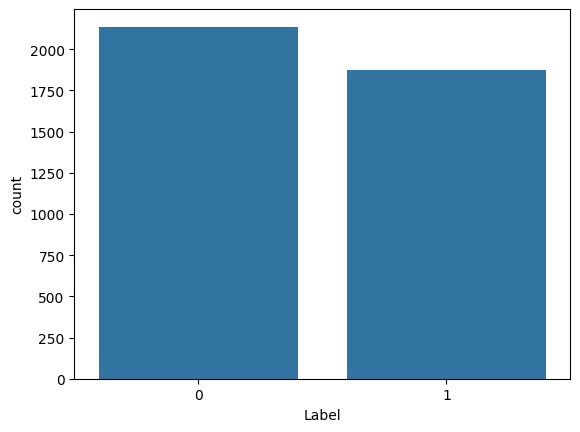

In [18]:
import seaborn as sns
sns.countplot(x='Label',data=news_dataset)

In [19]:
#merging the author name and news title
news_dataset['content']=news_dataset['Headline']+' '+news_dataset['Body']

In [20]:
print(news_dataset['content'])

0       Four ways Bob Corker skewered Donald Trump Ima...
1       Linklater's war veteran comedy speaks to moder...
2       Trump’s Fight With Corker Jeopardizes His Legi...
3       Egypt's Cheiron wins tie-up with Pemex for Mex...
4       Jason Aldean opens 'SNL' with Vegas tribute Co...
                              ...                        
4004    Trends to Watch Trends to Watch\n% of readers ...
4005    Trump Jr. Is Soon To Give A 30-Minute Speech F...
4006         Ron Paul on Trump, Anarchism & the AltRight 
4007    China to accept overseas trial data in bid to ...
4008    Vice President Mike Pence Leaves NFL Game Beca...
Name: content, Length: 4009, dtype: object


In [21]:
# seperating the data & label
X = news_dataset.drop(columns = 'Label', axis = 1)
Y = news_dataset['Label']

In [22]:
print(X)
print(Y)

                                                   URLs  \
0     http://www.bbc.com/news/world-us-canada-414191...   
1     https://www.reuters.com/article/us-filmfestiva...   
2     https://www.nytimes.com/2017/10/09/us/politics...   
3     https://www.reuters.com/article/us-mexico-oil-...   
4     http://www.cnn.com/videos/cnnmoney/2017/10/08/...   
...                                                 ...   
4004  http://beforeitsnews.com/sports/2017/09/trends...   
4005  http://beforeitsnews.com/u-s-politics/2017/10/...   
4006  https://www.activistpost.com/2017/09/ron-paul-...   
4007  https://www.reuters.com/article/us-china-pharm...   
4008  http://beforeitsnews.com/u-s-politics/2017/10/...   

                                               Headline  \
0            Four ways Bob Corker skewered Donald Trump   
1     Linklater's war veteran comedy speaks to moder...   
2     Trump’s Fight With Corker Jeopardizes His Legi...   
3     Egypt's Cheiron wins tie-up with Pemex for Mex...

In [23]:
X.head()

,URLs,Headline,Body,content
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,Four ways Bob Corker skewered Donald Trump Ima...
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",Linklater's war veteran comedy speaks to moder...
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,Trump’s Fight With Corker Jeopardizes His Legi...
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,Egypt's Cheiron wins tie-up with Pemex for Mex...
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",Jason Aldean opens 'SNL' with Vegas tribute Co...


Stemming;

Stemming is a process of reducing the word to root word

ex, actor,actress,acting --> act

In [24]:
port_stem = PorterStemmer()

In [25]:
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]',' ',content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content

In [26]:
news_dataset['content']=news_dataset['content'].apply(stemming)

In [27]:
print(news_dataset['content'])

0       four way bob corker skewer donald trump imag c...
1       linklat war veteran comedi speak modern americ...
2       trump fight corker jeopard legisl agenda feud ...
3       egypt cheiron win tie pemex mexican onshor oil...
4       jason aldean open snl vega tribut countri sing...
                              ...                        
4004    trend watch trend watch reader think stori fac...
4005    trump jr soon give minut speech trump jr soon ...
4006                       ron paul trump anarch altright
4007    china accept oversea trial data bid speed drug...
4008    vice presid mike penc leav nfl game anti ameri...
Name: content, Length: 4009, dtype: object


In [28]:
X = news_dataset['content'].values
Y = news_dataset['Label'].values

In [29]:
print(X)
print(Y)

['four way bob corker skewer donald trump imag copyright getti imag sunday morn donald trump went twitter tirad member parti exactli huge news far first time presid turn rhetor cannon rank time howev attack particularli bite person essenti call tennesse senat bob corker chair power senat foreign relat committe coward run elect said mr corker beg presid endors refus give wrongli claim mr corker support iranian nuclear agreement polit accomplish unlik colleagu mr corker free worri immedi polit futur hold tongu skip twitter post senbobcork shame white hous becom adult day care center someon obvious miss shift morn senat bob corker senbobcork octob report end though spoke new york time realli let presid four choic quot tennesse senat interview time particularli damn know presid tweet thing true know everyon know realli sugarcoat one mr corker flat say presid liar everyon know senat particular challeng mr trump insist unsuccess plead endors accus much broader mr corker presid use someth aki

In [30]:
Y.shape

(4009,)

In [31]:
#converting the textual data to a feature vectors
Vectorizer = TfidfVectorizer()
Vectorizer.fit(X)


TfidfVectorizer()

In [32]:
X = Vectorizer.transform(X)

In [33]:
print(X)

  (0, 30184)	0.015577335446991065
  (0, 30105)	0.010138100956414153
  (0, 29925)	0.04071381287423977
  (0, 29866)	0.02302556735837691
  (0, 29839)	0.02594843079913226
  (0, 29701)	0.02731627067801335
  (0, 29551)	0.0903446717463179
  (0, 29459)	0.021597618227067437
  (0, 29444)	0.017771302554684214
  (0, 29311)	0.02697433639807544
  (0, 29222)	0.018730200435309236
  (0, 29075)	0.021387359321615517
  (0, 28853)	0.02468949435722926
  (0, 28802)	0.024215820940514617
  (0, 28753)	0.03475630898700329
  (0, 28690)	0.029253905378133573
  (0, 28537)	0.02391375950042295
  (0, 28523)	0.024497471826251886
  (0, 28449)	0.019495776258929093
  (0, 28383)	0.036139116901976395
  (0, 28337)	0.03646156433375988
  (0, 28328)	0.037974920420926095
  (0, 28300)	0.037167646453401565
  (0, 28252)	0.023056310182459756
  (0, 28229)	0.01446617290179376
  :	:
  (4008, 6338)	0.042467699965906804
  (4008, 6225)	0.020215512049593334
  (4008, 5853)	0.03714317999258209
  (4008, 5597)	0.020634751853156684
  (4008, 5544

Splitting the dataset in training & test data

In [34]:
X_train , X_test , Y_train , Y_test = train_test_split(X,Y,test_size = 0.15, stratify=Y , random_state=3)

Training the Model : Logistic Regression model

In [35]:
model = LogisticRegression()

In [36]:
model.fit(X_train,Y_train)

LogisticRegression()

Evaluation:

Accuracy Score

In [37]:
# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [38]:
print('Accuracy Score of the training data :',training_data_accuracy)

Accuracy Score of the training data : 0.9914881127091283


In [39]:
# accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [40]:
print('Accuracy Score of the test data :',test_data_accuracy)

Accuracy Score of the test data : 0.9800664451827242


Making a Predictive System

In [49]:
X_new = X_test[3]

prediction = model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real


In [50]:
print(Y_test[3]) # checking the model

0
